In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [ ]:
import PIL
import math
import h5py
import scipy.io
import cv2
import os
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import cm as CM
from IPython.display import Image, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = os.path.join(os.getcwd(), "drive/My Drive/Dataset/ShanghaiTech/")
MODEL_SAVE_DIR = os.path.join(os.getcwd(), "drive/My Drive/Dataset/Model/")
PART_A_TRAIN_DATA = os.path.join(os.getcwd(), DATA_DIR + "part_A/train_data/images/")
PART_A_GROUND_TRUTH = os.path.join(os.getcwd(), DATA_DIR + "part_A/train_data/ground-truth/")
PART_A_GROUND_TRUTH_H5 = os.path.join(os.getcwd(), DATA_DIR + "part_A/train_data/ground-truth-h5/")
PART_B_TRAIN_DATA = os.path.join(os.getcwd(), DATA_DIR + "part_B/train_data/images/")
PART_B_GROUND_TRUTH = os.path.join(os.getcwd(), DATA_DIR + "part_B/train_data/ground-truth/")
PART_B_GROUND_TRUTH_H5 = os.path.join(os.getcwd(), DATA_DIR + "part_B/train_data/ground-truth-h5/")
PART_A_TEST_DATA = os.path.join(os.getcwd(), DATA_DIR + "part_A/test_data/images/")
PART_A_TEST_GROUND_TRUTH = os.path.join(os.getcwd(), DATA_DIR + "part_A/test_data/ground-truth/")
PART_A_TEST_GROUND_TRUTH_H5 = os.path.join(os.getcwd(), DATA_DIR + "part_A/test_data/ground-truth-h5/")
PART_B_TEST_DATA = os.path.join(os.getcwd(), DATA_DIR + "part_B/test_data/images/")
PART_B_TEST_GROUND_TRUTH = os.path.join(os.getcwd(), DATA_DIR + "part_B/test_data/ground-truth/")
PART_B_TEST_GROUND_TRUTH_H5 = os.path.join(os.getcwd(), DATA_DIR + "part_B/test_data/ground-truth-h5/")
    
X, y = [], []

In [ ]:
EPOCHS = 20
batch_size = 28
subsampling_factor = 4
IN_X, IN_Y = 768, 1024
OUT_X, OUT_Y = IN_X // subsampling_factor, IN_Y // subsampling_factor

In [ ]:
from scipy.ndimage.filters import gaussian_filter
import scipy.spatial

def gaussian_filter_density(img,points):
    '''
    This code use k-nearst, will take one minute or more to generate a density-map with one thousand people.
    points: a two-dimension list of pedestrians' annotation with the order [[col,row],[col,row],...].
    img_shape: the shape of the image, same as the shape of required density-map. (row,col). Note that can not have channel.
    return:
    density: the density-map we want. Same shape as input image but only has one channel.
    example:
    points: three pedestrians with annotation:[[163,53],[175,64],[189,74]].
    img_shape: (768,1024) 768 is row and 1024 is column.
    '''
    img_shape=[img.shape[0],img.shape[1]]
    print("Shape of current image: ",img_shape,". Totally need generate ",len(points),"gaussian kernels.")
    density = np.zeros(img_shape, dtype=np.float32)
    gt_count = len(points)
    if gt_count == 0:
        return density

    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(points.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(points, k=4)

#     print ('generate density...')
    for i, pt in enumerate(points):
        pt2d = np.zeros(img_shape, dtype=np.float32)
        if int(pt[1])<img_shape[0] and int(pt[0])<img_shape[1]:
            pt2d[int(pt[1]),int(pt[0])] = 1.
        else:
            continue
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print ('done.')
    return density

In [ ]:
class MCNN(nn.Module):
    def __init__(self,load_weights=False):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3,16,9,padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,16,7,padding=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(16,8,7,padding=3),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3,20,7,padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(20,40,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(40,20,5,padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(20,10,5,padding=2),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3,24,5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(24,48,3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(48,24,3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24,12,3,padding=1),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(nn.Conv2d(30,1,1,padding=0))

        if not load_weights:
            self._initialize_weights()

    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [ ]:
class CrowdDataset(Dataset):
    def __init__(self,img_root,gt_dmap_root,gt_downsample=1):
        '''
        img_root: the root path of img.
        gt_dmap_root: the root path of ground-truth density-map.
        gt_downsample: default is 0, denote that the output of deep-model is the same size as input image.
        '''
        self.img_root=img_root
        self.gt_dmap_root=gt_dmap_root
        self.gt_downsample=gt_downsample

        self.img_names=[filename for filename in sorted(os.listdir(img_root)) if os.path.isfile(os.path.join(img_root,filename))]
        # self.map_names=[filename for filename in sorted(os.listdir(gt_dmap_root)) if os.path.isfile(os.path.join(gt_dmap_root,filename))]
        self.n_samples=len(self.img_names)

    def __len__(self):
        return self.n_samples

    def __getitem__(self,index):
        assert index <= len(self)
        img_name=self.img_names[index]
        img=plt.imread(os.path.join(self.img_root,img_name))
        if len(img.shape)==2:
            img=img[:,:,np.newaxis]
            img=np.concatenate((img,img,img),2)

        gt_dmap=np.load(os.path.join(self.gt_dmap_root,img_name.replace('.jpg','.npy')))
        if self.gt_downsample>1: # to downsample image and density-map to match deep-model.
            ds_rows=int(img.shape[0]//self.gt_downsample)
            ds_cols=int(img.shape[1]//self.gt_downsample)
            img = cv2.resize(img,(ds_cols*self.gt_downsample,ds_rows*self.gt_downsample))
            img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
            gt_dmap=cv2.resize(gt_dmap,(ds_cols,ds_rows))
            gt_dmap=gt_dmap[np.newaxis,:,:]*self.gt_downsample*self.gt_downsample

            img_tensor=torch.tensor(img,dtype=torch.float)
            gt_dmap_tensor=torch.tensor(gt_dmap,dtype=torch.float)

        return img_tensor,gt_dmap_tensor

In [ ]:
def EuclidianError(x, y):
    loss = torch.sqrt(((x - y)**2).sum())
    return loss

Shape of current image:  [704, 1024] . Totally need generate  172 gaussian kernels.
Shape of current image:  [768, 1024] . Totally need generate  502 gaussian kernels.
Shape of current image:  [409, 902] . Totally need generate  389 gaussian kernels.
torch.Size([1, 1, 102, 225])
(102, 225)


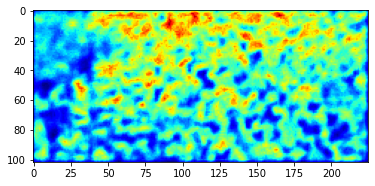

In [ ]:
# Load params to test
param_to_load = "2.param"
device=torch.device("cuda")
mcnn=MCNN().to(device)
mcnn.load_state_dict(torch.load(MODEL_SAVE_DIR + param_to_load))
index = 2

dataset=CrowdDataset(PART_A_TEST_DATA,PART_A_TEST_GROUND_TRUTH,4)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
mcnn.eval()
for i,(img,gt_dmap) in enumerate(dataloader):
    if i==index:
        img=img.to(device)
        gt_dmap=gt_dmap.to(device)
        # forward propagation
        et_dmap=mcnn(img).detach()
        print(et_dmap.shape)
        et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
        print(et_dmap.shape)
        plt.imshow(et_dmap,cmap=CM.jet)
        break

Shape of current image:  [704, 1024] . Totally need generate  172 gaussian kernels.
Shape of current image:  [768, 1024] . Totally need generate  502 gaussian kernels.
Shape of current image:  [409, 902] . Totally need generate  389 gaussian kernels.
(102, 225)


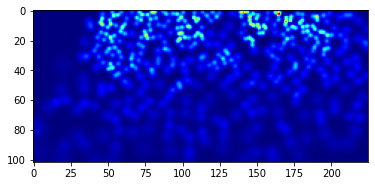

In [ ]:
for i,(img,gt_dmap) in enumerate(dataloader):
    if i==index:
        img=img.to(device)
        gt_dmap=gt_dmap.to(device)
        gt_dmap=gt_dmap.squeeze(0).squeeze(0).cpu().numpy()
        print(gt_dmap.shape)
        plt.imshow(gt_dmap,cmap=CM.jet)
        break

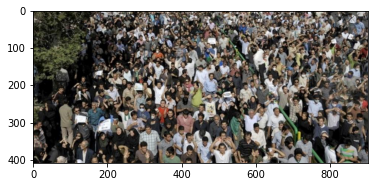

In [ ]:
img_names=[filename for filename in sorted(os.listdir(PART_A_TEST_DATA)) if os.path.isfile(os.path.join(PART_A_TEST_DATA,filename))]
img_name = img_names[index]
im = plt.imread(os.path.join(PART_A_TEST_DATA, img_name))
plt.imshow(im)

In [ ]:
mat_names=[filename for filename in sorted(os.listdir(PART_A_TEST_GROUND_TRUTH)) if os.path.isfile(os.path.join(PART_A_TEST_GROUND_TRUTH,filename))]
mat_name = mat_names[index]
mat = scipy.io.loadmat(os.path.join(PART_A_TEST_GROUND_TRUTH,mat_name))
groundtruth = mat["image_info"][0,0][0,0][0]
np.squeeze(groundtruth).shape[0]

389

In [ ]:
np.sum(np.abs(et_dmap))

60.409504

In [ ]:
mae=0
check_for = 20
with torch.no_grad():
    for i,(img,gt_dmap) in enumerate(dataloader):
        img=img.to(device)
        gt_dmap=gt_dmap.to(device)
        # forward propagation
        et_dmap=mcnn(img)
        mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
        avg_mae = mae / (i+1)
        print("Average MAE after " + str(i) + " images: " + str(avg_mae))
        if i == check_for-1:
            break
        del img,gt_dmap,et_dmap

Shape of current image:  [704, 1024] . Totally need generate  172 gaussian kernels.
Average MAE after 0 images: 208.33236694335938
Shape of current image:  [768, 1024] . Totally need generate  502 gaussian kernels.
Average MAE after 1 images: 304.0003204345703
Shape of current image:  [409, 902] . Totally need generate  389 gaussian kernels.
Average MAE after 2 images: 336.7463073730469
Shape of current image:  [768, 962] . Totally need generate  211 gaussian kernels.
Average MAE after 3 images: 315.55671310424805
Shape of current image:  [276, 460] . Totally need generate  223 gaussian kernels.
Average MAE after 4 images: 278.8302856445313
Shape of current image:  [666, 1024] . Totally need generate  431 gaussian kernels.
Average MAE after 5 images: 311.5293477376302
Shape of current image:  [683, 1024] . Totally need generate  1175 gaussian kernels.
Average MAE after 6 images: 416.71331787109375
Shape of current image:  [661, 1024] . Totally need generate  265 gaussian kernels.
Avera

Shape of current image:  [704, 1024] . Totally need generate  172 gaussian kernels.
Shape of current image:  [768, 1024] . Totally need generate  502 gaussian kernels.
Shape of current image:  [409, 902] . Totally need generate  389 gaussian kernels.
torch.Size([1, 1, 102, 225])
(102, 225)


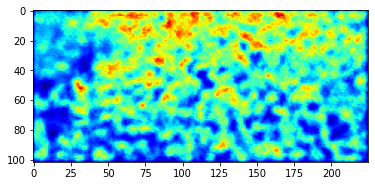

In [ ]:
# Load params to test
param_to_load = "2.param"
device=torch.device("cuda")
mcnn2=MCNN().to(device)
mcnn2.load_state_dict(torch.load(MODEL_SAVE_DIR + param_to_load))
index = 2

dataset=CrowdDataset(PART_A_TEST_DATA,PART_A_TEST_GROUND_TRUTH,4)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
mcnn.eval()
for i,(img,gt_dmap) in enumerate(dataloader):
    if i==index:
        img=img.to(device)
        gt_dmap=gt_dmap.to(device)
        # forward propagation
        et_dmap=mcnn2(img).detach()
        print(et_dmap.shape)
        et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
        print(et_dmap.shape)
        plt.imshow(et_dmap,cmap=CM.jet)
        break

In [ ]:
mae=0
check_for = 20
with torch.no_grad():
    for i,(img,gt_dmap) in enumerate(dataloader):
        img=img.to(device)
        gt_dmap=gt_dmap.to(device)
        # forward propagation
        et_dmap=mcnn2(img)
        mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
        avg_mae = mae / (i+1)
        print("Average MAE after " + str(i) + " images: " + str(avg_mae))
        if i == check_for-1:
            break
        del img,gt_dmap,et_dmap

Shape of current image:  [704, 1024] . Totally need generate  172 gaussian kernels.
Average MAE after 0 images: 317.1881103515625
Shape of current image:  [768, 1024] . Totally need generate  502 gaussian kernels.
Average MAE after 1 images: 247.69720458984375
Shape of current image:  [409, 902] . Totally need generate  389 gaussian kernels.
Average MAE after 2 images: 208.30016072591147
Shape of current image:  [768, 962] . Totally need generate  211 gaussian kernels.
Average MAE after 3 images: 228.4444351196289
Shape of current image:  [276, 460] . Totally need generate  223 gaussian kernels.
Average MAE after 4 images: 189.64700012207032
Shape of current image:  [666, 1024] . Totally need generate  431 gaussian kernels.
Average MAE after 5 images: 158.53383127848306
Shape of current image:  [683, 1024] . Totally need generate  1175 gaussian kernels.
Average MAE after 6 images: 209.12768336704798
Shape of current image:  [661, 1024] . Totally need generate  265 gaussian kernels.
Ave

In [ ]:
# Train on part B data
import math
import tqdm

batch_size = 15
epochs = 1000
param_to_load = "2.param"

if torch.cuda.is_available():
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    # mcnn.load_state_dict(torch.load(MODEL_SAVE_DIR + param_to_load))
    criterion=nn.MSELoss(size_average=False).to(device)
    optimizer = torch.optim.SGD(mcnn.parameters(), lr=1e-6, momentum=0.95)
    dataset=CrowdDataset(PART_B_TRAIN_DATA,PART_B_GROUND_TRUTH,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    #training phase
    min_mae=10000
    min_epoch=0
    train_loss_list=[]
    epoch_list=[]
    total_batches = math.ceil(len(os.listdir(PART_B_TRAIN_DATA)) / batch_size)
    print("Total Epochs: " + str(epochs) + ", Batches per epoch: " + str(total_batches))
    
    for epoch in range(0,epochs):
        print("Epoch: " + str(epoch))
        mcnn.train()
        epoch_loss=0
        for i,data in enumerate(dataloader):
            # print("Batch: " + str(i))
            img, gt_dmap = data
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img)
            # calculate loss
            loss=criterion(et_dmap,gt_dmap)
            # print("Batch loss: " + str(loss))
            epoch_loss+=loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("epoch:",epoch,"loss:",epoch_loss/len(dataloader))
        epoch_list.append(epoch)
        train_loss_list.append(epoch_loss/len(dataloader))
        torch.save(mcnn.state_dict(),MODEL_SAVE_DIR+str(epoch)+".param")


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Total Epochs: 1000, Batches per epoch: 27
Epoch: 0
epoch: 0 loss: 175.56482265613698
Epoch: 1
epoch: 1 loss: 169.6962458292643
Epoch: 2
epoch: 2 loss: 171.1374319571036
Epoch: 3
epoch: 3 loss: 173.0624710365578
Epoch: 4
epoch: 4 loss: 182.5058285748517
Epoch: 5
epoch: 5 loss: 185.30296693024812
Epoch: 6
epoch: 6 loss: 179.99939826682763
Epoch: 7
epoch: 7 loss: 187.99446981924552
Epoch: 8
epoch: 8 loss: 161.6352803265607
Epoch: 9
epoch: 9 loss: 160.24856962981048
Epoch: 10
epoch: 10 loss: 157.63360002305774
Epoch: 11
epoch: 11 loss: 161.96837220368562
Epoch: 12
epoch: 12 loss: 170.99424404568143
Epoch: 13
epoch: 13 loss: 160.3270344204373
Epoch: 14
epoch: 14 loss: 174.04984523631907
Epoch: 15
epoch: 15 loss: 165.0681618584527
Epoch: 16
epoch: 16 loss: 152.02870969419126
Epoch: 17
epoch: 17 loss: 159.74587447554975
Epoch: 18
epoch: 18 loss: 159.03973897298178
Epoch: 19
epoch: 19 loss: 156.80993864271375
Epoch: 20
epoch: 20 loss: 152.82315840544524
Epoch: 21
epoch: 21 loss: 148.3793588567

In [ ]:
#Save the model
torch.save(mcnn.state_dict(), MODEL_SAVE_DIR + "part_b_only_trained.param")

In [ ]:
def cal_mae(img_root,gt_dmap_root,model_param_path):
    '''
    Calculate the MAE of the test data.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    '''
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    mcnn.load_state_dict(torch.load(model_param_path))
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    mae=0
    with torch.no_grad():
        for i,(img,gt_dmap) in enumerate(dataloader):
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img)
            mae+=abs(et_dmap.data.sum()-gt_dmap.data.sum()).item()
            del img,gt_dmap,et_dmap

    print("model_param_path:"+model_param_path+" MAE:"+str(mae/len(dataloader)))

def estimate_density_map(img_root,gt_dmap_root,model_param_path,index):
    '''
    Show one estimated density-map.
    img_root: the root of test image data.
    gt_dmap_root: the root of test ground truth density-map data.
    model_param_path: the path of specific mcnn parameters.
    index: the order of the test image in test dataset.
    '''
    device=torch.device("cuda")
    mcnn=MCNN().to(device)
    mcnn.load_state_dict(torch.load(model_param_path))
    dataset=CrowdDataset(img_root,gt_dmap_root,4)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)
    mcnn.eval()
    for i,(img,gt_dmap) in enumerate(dataloader):
        if i==index:
            img=img.to(device)
            gt_dmap=gt_dmap.to(device)
            # forward propagation
            et_dmap=mcnn(img).detach()
            et_dmap=et_dmap.squeeze(0).squeeze(0).cpu().numpy()
            print(et_dmap.shape)
            plt.imshow(et_dmap,cmap=CM.jet)
            break

In [ ]:
cal_mae(PART_B_TRAIN_DATA,PART_B_GROUND_TRUTH, MODEL_SAVE_DIR + "part_b_trained.param")

model_param_path:/content/drive/My Drive/Dataset/Model/part_b_trained.param MAE:131.2159312200546


(192, 256)


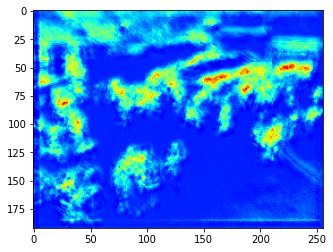

In [ ]:
estimate_density_map(PART_B_TRAIN_DATA,PART_B_GROUND_TRUTH, MODEL_SAVE_DIR + "part_b_trained.param", 5)

(153, 204)


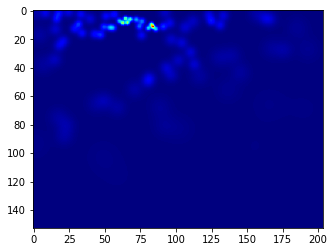

In [ ]:
dataset=CrowdDataset(PART_B_TRAIN_DATA,PART_B_GROUND_TRUTH,5)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False)

for i,(img,gt_dmap) in enumerate(dataloader):
    if i == 3:
        map = gt_dmap.squeeze(0).squeeze(0).cpu().numpy()
        print(map.shape)
        plt.imshow(map,cmap=CM.jet)
        break

In [ ]:
torch.cuda.empty_cache()